# This File

* Load experiments to test agents in scenarios and record behavior
* Load agents to record their actions
* Load agents to get video recordings of episodes

# Evaluation

Here we are working on setting up code to attempt to evaluate the agent in their behavior

In [2]:
import gym
import gym_nav
import torch
import sys
sys.path.insert(0, '..')
from evaluation import evaluate
from a2c_ppo_acktr.model import Policy
from a2c_ppo_acktr.envs import make_vec_envs
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pickle
from pathlib import Path
import re
from matplotlib import animation
from IPython.display import HTML

eval_log_dir = '/tmp/gym/_eval'
device = torch.device("cpu")

save_folder = 'plots/proof_of_concept/'


In [3]:
def data_callback(actor_critic, vec_envs, recurrent_hidden_states, 
                  obs, action, reward, data):
    '''
    assume only working with a single environment for easier coding
    '''
    if data == {}:
        data['goal'] = []
        data['agent'] = []
        data['facing_goal'] = []
        data['dist_from_goal'] = []
    
    agent = vec_envs.get_attr('agent')[0]
    objects = vec_envs.get_attr('objects')[0]
    
    goal_y = (objects == 2).argmax(axis=0).max()
    goal_x = (objects == 2).argmax(axis=1).max()
    data['goal'].append([goal_y, goal_x])
    
    #check if agent is facing the goal
    correct_directions = np.array([False, False, False, False])
    if goal_y > agent[0][0]:
        correct_directions[1] = True
    if goal_y < agent[0][0]:
        correct_directions[3] = True
    if goal_x > agent[0][1]:
        correct_directions[0] = True
    if goal_x < agent[0][1]:
        correct_directions[2] = True
    
    if correct_directions[agent[1]]:
        data['facing_goal'].append(True)
    else:
        data['facing_goal'].append(False)
        
        
    dist_from_goal = np.abs(goal_y - agent[0][0]) + np.abs(goal_x - agent[0][1])
    data['dist_from_goal'].append(dist_from_goal)
    # vec_envs.env_method('render')
    
    data['agent'].append(agent.copy())
    
    return data

    
    
def get_ep(data, ep_num=0):
    '''
    Pass data and a data block to grab data from this episode n alone
    E.g., call get_ep(hidden_states, 1) to get the hidden states for the 2nd episode
    '''
    if ep_num == 0:
        ep_start = 0
    else:
        ep_start = ep_ends[ep_num - 1]
    
    ep_end = ep_ends[ep_num]
    return data[ep_start:ep_end]



    
    
    
    
def load_model_and_env(experiment, base_folder='../trained_models/ppo/'):
    '''
    Load a model along with its environment
    Use the fact that all saved models end with _i where i indicates the trial number
    
    For scenario name, include any folder directions starting from trained_models/ppo/
    E.g., for the poster scenario might use scenario_name = 'invisible_poster/invisible_poster_0_shape_0_0.pt'
    
    Note that after training has been completed, we need to manually go back to write_experiments.ipynb
    to add the appropriate env kwargs to the trained models folder
    
    Return: model, obs_rms, env_kwargs
    '''
    
    env_file = '_'.join(experiment.split('_')[:-1]) + '_env'
    try:
        env_kwargs = pickle.load(open(base_folder + env_file, 'rb'))
    except:
        Exception('Error loading env_kwargs, make sure that they have been saved from write_experiments.ipynb')
    # env = gym.make('Gridworld-v0', **env_kwargs)
    
    model, obs_rms = torch.load(base_folder + experiment)
    
    return model, obs_rms, env_kwargs





def print_trained_models(folder='../trained_models/ppo/', ignore_non_pt=True,
                        ignore_non_dir_in_first=True):
    '''
    Read the trained_models folder to see what models have been trained
    ignore_non_pt: don't print files without .pt extension
    ignore_non_dir_in_first: don't print files in the parent folder, skip straight to directories
    '''
    
    space =  '    '
    branch = '│   '
    tee =    '├── '
    last =   '└── '
    
    path = Path(folder)
    print(path.name)
    
    def inner_print(path, depth, ignore_non_pt=ignore_non_pt, ignore_non_dir_in_first=ignore_non_dir_in_first):
        directories = []
        unique_experiments = {}
        original_experiment_names = {}
        for d in path.iterdir():
            if d.is_dir():
                directories.append(d)
            elif d.suffix == '.pt':
                if not re.match('.*\_\d*\.pt', d.name) and not (ignore_non_dir_in_first and depth == 0):
                    #not a trial, simply print
                    print(branch*depth+tee+d.name)
                exp_name = '_'.join(d.name.split('_')[:-1])
                if exp_name in unique_experiments.keys():
                    unique_experiments[exp_name] += 1
                else:
                    unique_experiments[exp_name] = 1
                    original_experiment_names[exp_name] = d.name
            elif not ignore_non_pt:
                print(branch*depth+tee+d.name)
        for key, value in unique_experiments.items():
            if ignore_non_dir_in_first and depth == 0:
                break
            if value > 1:
                print(branch*depth + tee+'EXP', key + ':', value)
            else:
                print(branch*depth+tee+original_experiment_names[key])
        for d in directories:
            print(branch*depth + tee+d.name)
            inner_print(d, depth+1, ignore_non_pt, ignore_non_dir_in_first)
            
    inner_print(path, 0, ignore_non_pt, ignore_non_dir_in_first)    
    
    
    
    
def animate_episode(ep_num=0, trajectory=False):
    #generate frames of episode
    rgb_array = []
    agent = get_ep(data['agent'], ep_num)
    goal = get_ep(data['goal'], ep_num)[0]
    for i in range(1, env.world_size[0]-1):
        for j in range(1, env.world_size[1]-1):
            env.objects[i, j] = 0
            env.visible[i, j] = 0
    env.objects[goal[0], goal[1]] = 1
    env.visible[goal[0], goal[1]] = 6

    for a in agent:
        env.agent[0][0] = a[0][0]
        env.agent[0][1] = a[0][1]
        env.agent[1] = a[1]
        rgb_array.append(env.render('rgb_array'))

    rgb_array = np.array(rgb_array)
    
    if trajectory:
        #generate trajectory
        trajectory = get_ep(all_trajectories, ep_num)
        scat_min = np.min(all_trajectories)
        scat_max = np.max(all_trajectories)


        fig, ax = plt.subplots(1, 2, figsize=(10,5))
        
        im = ax[0].imshow(rgb_array[0,:,:,:])
        x, y = np.full(trajectory.shape[0], -100.0), np.full(trajectory.shape[0], -100.0)
        scatter = ax[1].scatter(x, y)
        ax[1].set_xlim([scat_min, scat_max])
        ax[1].set_ylim([scat_min, scat_max])

        plt.close() # this is required to not display the generated image

        def init():
            im.set_data(rgb_array[0,:,:,:])
            scatter.set_offsets(np.c_[x, y])

        def animate(i):
            im.set_data(rgb_array[i,:,:,:])
            x[:i+1] = trajectory.T[0][:i+1]
            y[:i+1] = trajectory.T[1][:i+1]
            scatter.set_offsets(np.c_[x, y])
            # print(np.c_[x, y])
            return im, scatter,

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=rgb_array.shape[0],
                                       interval=500)
    else:
        fig = plt.figure(figsize=(6,6))
        
        im = plt.imshow(rgb_array[0,:,:,:])
        plt.close() # this is required to not display the generated image

        def init():
            im.set_data(rgb_array[0,:,:,:])

        def animate(i):
            im.set_data(rgb_array[i,:,:,:])
            return im

        anim = animation.FuncAnimation(fig, animate, init_func=init, frames=rgb_array.shape[0],
                                       interval=500)

    # fig = plt.figure()
    return HTML(anim.to_html5_video())



def evalu(n=100, env_name='Gridworld-v0', data_callback=None, capture_video=False, verbose=False):
    '''
    Evaluate using the current global model, obs_rms, and env_kwargs
    Load ep_ends, ep_lens into global vars to be used by get_ep
        as well as all_obs, all_actions, all_rewards, all_hidden_states, all_dones, eval_envs, data
        
    capture_video: whether video should be captured
    verbose: print every episode
    '''
    global model, obs_rms, env_kwargs, ep_lens, ep_ends
    global all_obs, all_actions, all_rewards, all_hidden_states, all_dones, eval_envs, data
    global env
    
    all_obs, all_actions, all_rewards, all_hidden_states, all_dones, \
    eval_envs, data = evaluate(model, obs_rms, env_name, 1, 1, eval_log_dir, device, 
         env_kwargs=env_kwargs, data_callback=data_callback, num_episodes=n, capture_video=capture_video,
         verbose=verbose)

    #ep_ends and ep_lens used to easily pull data for single episodes
    ep_ends = np.where(np.array(all_dones).flatten())[0]
    ep_lens = np.diff(ep_ends)
    
    env = gym.make(env_name, **env_kwargs)

    #code for computing PCA of hidden_states over all evaluated episodes
    
    global all_trajectories, hidden_states
    
    hidden_states = np.zeros((len(all_hidden_states), all_hidden_states[0].shape[1]))
    for i in range(len(all_hidden_states)):
        hidden_states[i] = all_hidden_states[i].numpy()[0]

    pca = PCA(n_components=2)
    pca.fit(hidden_states)

    all_trajectories = pca.transform(hidden_states)

    # len(pca.transform(hidden_states))

In [4]:
print_trained_models()

ppo
├── invisible_poster
│   ├── EXP invisible_poster_0_shape_0: 5
│   ├── EXP invisible_poster_0_shape_1: 5
│   ├── EXP invisible_poster_1_shape_0: 5
│   ├── EXP invisible_poster_1_shape_1: 5
├── invisible_wallcolors
│   ├── EXP invisible_0_1: 10
│   ├── EXP invisible_0_2.5: 3
│   ├── EXP invisible_0_2: 3
│   ├── EXP invisible_0_4: 3
│   ├── EXP invisible_1_1: 10
│   ├── EXP invisible_1_2.5: 3
│   ├── EXP invisible_1_2: 3
│   ├── EXP invisible_1_4: 3
├── nav_visible_reshaping
│   ├── EXP nav_visible_dist: 5
│   ├── EXP nav_visible_none: 5
├── visible_reshaping
│   ├── EXP grid_reshaping_0: 9
│   ├── EXP grid_reshaping_1: 9
│   ├── EXP grid_reshaping_2: 7
│   ├── EXP grid_reshaping_3: 7
├── visible_wallcolors
│   ├── EXP wallcolors_1: 10
│   ├── EXP wallcolors_2.5: 10
│   ├── EXP wallcolors_2: 10
│   ├── EXP wallcolors_4: 10


In [54]:
env = gym.make('Gridworld-v0', **env_kwargs)

In [2]:
folder = '../trained_models/ppo/'
eval_log_dir = '/tmp/gym/_eval'
device = torch.device("cpu")

env_kwargs = {'world_size': 14, 'num_obstacles': 0, 'give_dist': True, 'give_time': True}
env_name = 'Gridworld-v0'
num_processes = 1
seed = 1
capture_video = 0

actor_critic, obs_rms = torch.load(folder + 'grid_reshaping_1.pt')

In [30]:
obs_rms.mean

array([ 1.15580107,  1.19253791,  1.38345471,  1.16472965,  1.07075518,
        5.61045988,  5.95620509,  6.22151834,  6.02793295,  5.73767955,
       59.68326003])

In [3]:
eval_envs = make_vec_envs('Gridworld-v0', 1, 1, None, eval_log_dir, device,
                          True, capture_video=False, env_kwargs=env_kwargs)
eval_envs2 = make_vec_envs('Gridworld-v0', 1, 2, None, eval_log_dir, device,
                          True, capture_video=False, env_kwargs=env_kwargs)

In [24]:
all_obs, all_actions, all_rewards, all_hidden_states, all_dones, \
    eval_envs, data = evaluate(actor_critic, obs_rms, 'Gridworld-v0', 1, 1, eval_log_dir, device, 
         env_kwargs=env_kwargs, data_callback=data_callback, num_episodes=100)

 Evaluation using 100 episodes: mean reward 0.92000



In [31]:
folder = '../trained_models/ppo/visible_reshaping/'
eval_log_dir = '/tmp/gym/_eval'
device = torch.device("cpu")

env_kwargs = {'world_size': 14, 'num_obstacles': 0, 'give_dist': True, 'give_time': True}
env_name = 'Gridworld-v0'
num_processes = 1
seed = 1
capture_video = 0

actor_critic, obs_rms = torch.load(folder + 'grid_reshaping_1_0.pt')

In [33]:
all_obs, all_actions, all_rewards, all_hidden_states, all_dones, \
    eval_envs, data = evaluate(actor_critic, obs_rms, 'Gridworld-v0', 1, 1, eval_log_dir, device, 
         env_kwargs=env_kwargs, data_callback=data_callback, num_episodes=100)

 Evaluation using 100 episodes: mean reward 0.92000



In [3]:
folder = '../trained_models/ppo/visible_wallcolors/'
eval_log_dir = '/tmp/gym/_eval'
device = torch.device("cpu")

env_kwargs = {'world_size': 14, 'num_obstacles': 0, 'give_dist': True, 'give_time': True, 'wall_colors': 1}
env_name = 'Gridworld-v0'
num_processes = 1
seed = 1
capture_video = 0

actor_critic, obs_rms = torch.load(folder + 'wallcolors_1_0.pt')

In [4]:
all_obs, all_actions, all_rewards, all_hidden_states, all_dones, \
    eval_envs, data = evaluate(actor_critic, obs_rms, 'Gridworld-v0', 1, 1, eval_log_dir, device, 
         env_kwargs=env_kwargs, data_callback=data_callback, num_episodes=100)

 Evaluation using 100 episodes: mean reward 1.00000



(array([307., 271., 242., 205., 114., 217., 172.,  77.,  36.,  41.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <a list of 10 Patch objects>)

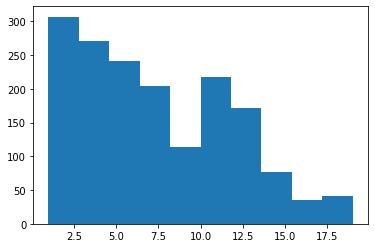

In [56]:
plt.hist(data['dist_from_goal'])

In [43]:
np.array(data['facing_goal']).mean()

0.46313912009512487

In [181]:
folder = '../trained_models/ppo/visible_wallcolors/'
eval_log_dir = '/tmp/gym/_eval'
device = torch.device("cpu")

env_kwargs = {'world_size': 14, 'num_obstacles': 0, 'give_dist': True, 'give_time': True, 'wall_colors': 2.5}
env_name = 'Gridworld-v0'
num_processes = 1
seed = 1
capture_video = 0

actor_critic, obs_rms = torch.load(folder + 'wallcolors_2.5_0.pt')

all_obs, all_actions, all_rewards, all_hidden_states, all_dones, \
    eval_envs, data = evaluate(actor_critic, obs_rms, 'Gridworld-v0', 1, 1, eval_log_dir, device, 
         env_kwargs=env_kwargs, data_callback=data_callback, num_episodes=100)

 Evaluation using 100 episodes: mean reward 1.00000



In [182]:
hidden_states = np.zeros((len(all_hidden_states), all_hidden_states[0].shape[1]))
for i in range(len(all_hidden_states)):
    hidden_states[i] = all_hidden_states[i].numpy()[0]

pca = PCA(n_components=2)
pca.fit(hidden_states)

ep_ends = np.where(np.array(all_dones).flatten())[0]
ep_lens = np.diff(ep_ends)

len(pca.transform(hidden_states))

1926

In [183]:
env = gym.make('Gridworld-v0', **env_kwargs)

In [84]:
from matplotlib import animation
from IPython.display import HTML

In [185]:
ep_num = 4

#generate frames of episode
rgb_array = []
agent = get_ep(data['agent'], ep_num)
goal = get_ep(data['goal'], ep_num)[0]
for i in range(1, env.world_size[0]-1):
    for j in range(1, env.world_size[1]-1):
        env.objects[i, j] = 0
        env.visible[i, j] = 0
env.objects[goal[0], goal[1]] = 1
env.visible[goal[0], goal[1]] = 6

for a in agent:
    env.agent[0][0] = a[0][0]
    env.agent[0][1] = a[0][1]
    env.agent[1] = a[1]
    rgb_array.append(env.render('rgb_array'))
    
rgb_array = np.array(rgb_array)

#generate trajectory
trajectory = get_ep(all_trajectories, ep_num)
scat_min = np.min(all_trajectories)
scat_max = np.max(all_trajectories)


fig, ax = plt.subplots(1, 2, figsize=(10,5))
# fig = plt.figure()
im = ax[0].imshow(rgb_array[0,:,:,:])
x, y = np.full(trajectory.shape[0], -100.0), np.full(trajectory.shape[0], -100.0)
scatter = ax[1].scatter(x, y)
ax[1].set_xlim([scat_min, scat_max])
ax[1].set_ylim([scat_min, scat_max])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(rgb_array[0,:,:,:])
    scatter.set_offsets(np.c_[x, y])

def animate(i):
    im.set_data(rgb_array[i,:,:,:])
    x[:i+1] = trajectory.T[0][:i+1]
    y[:i+1] = trajectory.T[1][:i+1]
    scatter.set_offsets(np.c_[x, y])
    # print(np.c_[x, y])
    return im, scatter,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=rgb_array.shape[0],
                               interval=500)
HTML(anim.to_html5_video())

In [91]:
animate_episode(6,trajectory=True)

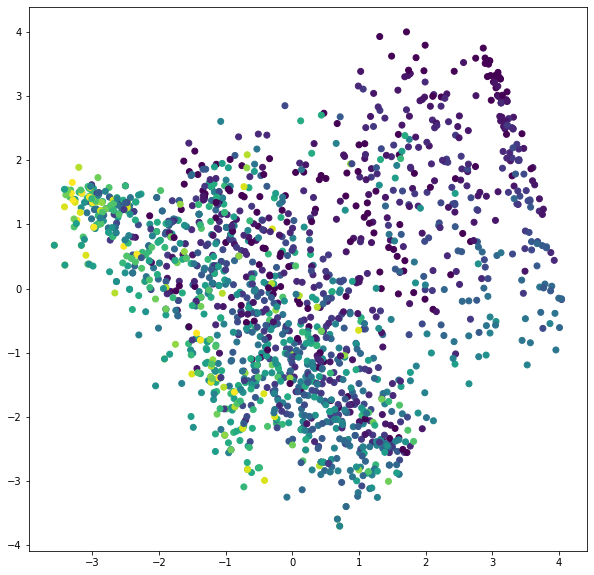

In [30]:
all_trajectories = pca.transform(hidden_states)
plt.figure(figsize=(10,10))
plt.scatter(all_trajectories.T[0], all_trajectories.T[1], c=np.array(data['dist_from_goal']))

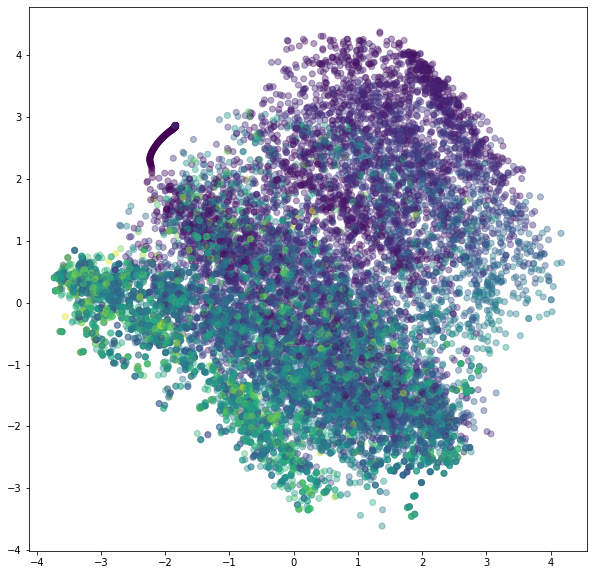

In [36]:
all_trajectories = pca.transform(hidden_states)
plt.figure(figsize=(10,10))
plt.scatter(all_trajectories.T[0], all_trajectories.T[1], c=np.array(data['dist_from_goal']), alpha=0.4)

## Analysing poster scenario more clearly

The goal here is to understand why reward shaping is detrimental to learning in the poster scenario. Things to consider tracking.

Measurements for fully trained agents
* How often is the poster sought out specifically? - Should distinguish between different strategies of heading towards goal first vs. trying to find platform first
    * How early is it seen? (Might also compare this against the visible platform 1 wall color task, since the idea would be similar in that we should be exploring to find something in vision first)
* How confidently is navigation performed after the platform has been seen? - Shows if the poster is actually being used in navigation
    * Measure steps from first sight of poster to platform
    * Compare with minimum number of steps required from position - this can be a general confidence metric
    
Measurements during training process
* How often is the poster seen before goal is reached? - Also may slightly distinguish between whether reward shaping is affecting goal
* Steps taken in direction of goal vs away - 
    
    

In [6]:
print_trained_models()

ppo
├── invisible_poster
│   ├── EXP invisible_poster_0_shape_0: 5
│   ├── EXP invisible_poster_0_shape_1: 5
│   ├── EXP invisible_poster_1_shape_0: 5
│   ├── EXP invisible_poster_1_shape_1: 5
├── invisible_wallcolors
│   ├── EXP invisible_0_1: 10
│   ├── EXP invisible_0_2.5: 3
│   ├── EXP invisible_0_2: 3
│   ├── EXP invisible_0_4: 3
│   ├── EXP invisible_1_1: 10
│   ├── EXP invisible_1_2.5: 3
│   ├── EXP invisible_1_2: 3
│   ├── EXP invisible_1_4: 3
├── visible_reshaping
│   ├── EXP grid_reshaping_0: 9
│   ├── EXP grid_reshaping_1: 9
│   ├── EXP grid_reshaping_2: 7
│   ├── EXP grid_reshaping_3: 7
├── visible_wallcolors
│   ├── EXP wallcolors_1: 10
│   ├── EXP wallcolors_2.5: 10
│   ├── EXP wallcolors_2: 10
│   ├── EXP wallcolors_4: 10


In [4]:
model, obs_rms, env_kwargs = load_model_and_env('invisible_poster/invisible_poster_0_shape_0_0.pt')

In [7]:
all_obs, all_actions, all_rewards, all_hidden_states, all_dones, \
    eval_envs, data = evaluate(model, obs_rms, 'Gridworld-v0', 1, 1, eval_log_dir, device, 
         env_kwargs=env_kwargs, data_callback=data_callback, num_episodes=100)

 Evaluation using 100 episodes: mean reward 1.00000



### Confidence Before and After Seeing Poster

In [21]:
def data_callback(actor_critic, vec_envs, recurrent_hidden_states, 
                  obs, action, reward, data):
    '''
    assume only working with a single environment for easier coding
    '''
    if data == {}:
        data['goal'] = []
        data['agent'] = []
        data['facing_goal'] = []
        data['dist_from_goal'] = []
        data['moved_towards_goal'] = []
        data['poster_in_sight'] = []
        data['obs'] = []
        data['colors'] = []
        data['goal_directions'] = []
    
    agent = vec_envs.get_attr('agent')[0]
    objects = vec_envs.get_attr('objects')[0]
    
    goal_y = (objects == 2).argmax(axis=0).max()
    goal_x = (objects == 2).argmax(axis=1).max()
    data['goal'].append([goal_y, goal_x])
    
    #check if agent is facing the goal
    correct_directions = np.array([False, False, False, False])
    if goal_y > agent[0][0]:
        correct_directions[3] = True
    if goal_y < agent[0][0]:
        correct_directions[1] = True
    if goal_x > agent[0][1]:
        correct_directions[0] = True
    if goal_x < agent[0][1]:
        correct_directions[2] = True
        
    data['goal_directions'].append(correct_directions)
    
    if correct_directions[agent[1]]:
        facing_goal = True
    else:
        facing_goal = False
    data['facing_goal'].append(facing_goal)
        
    #check if agent is making a move towards the goal
        #either needed to move forward while facing goal, or
        #turn towards goal when we weren't previously facing it
    if action == 1:
        #calculate previous position
        prev_pos = agent[0].copy()
        if agent[1] == 0:
            prev_pos[1] -= 1
        elif agent[1] == 1:
            prev_pos[0] += 1
        elif agent[1] == 2:
            prev_pos[1] += 1
        elif agent[1] == 3:
            prev_pos[0] -= 1
        prev_correct_directions = np.array([False, False, False, False])
        if goal_y > agent[0][0]:
            prev_correct_directions[3] = True
        if goal_y < agent[0][0]:
            prev_correct_directions[1] = True
        if goal_x > agent[0][1]:
            prev_correct_directions[0] = True
        if goal_x < agent[0][1]:
            prev_correct_directions[2] = True
        prev_facing_goal = prev_correct_directions[agent[1]]
        
        if prev_facing_goal:
            moved_towards_goal = True
        else:
            moved_towards_goal = False
    elif action == 0 or action == 2 and facing_goal and data['facing_goal'][-2] == False:
        moved_towards_goal = True
    else:
        moved_towards_goal = False
    data['moved_towards_goal'].append(moved_towards_goal)
    
    #check if poster is in sight (yellow has color value 4)
    #note that since we never see initial state, it is possible that agent will see
    #the poster and turn away from it immediately, so to be sure we are capturing
    #enough behavioral information, will want to manually check if poster seen in first step
    obs = vec_envs.env_method('get_observation')[0][0]
    colors = obs[:5]
    data['colors'].append(colors)
    data['obs'].append(obs)
    # print(colors)
    if np.any(colors == 4):
        data['poster_in_sight'].append(True)
    else:
        data['poster_in_sight'].append(False)
        
        
        
    dist_from_goal = np.abs(goal_y - agent[0][0]) + np.abs(goal_x - agent[0][1])
    data['dist_from_goal'].append(dist_from_goal)
    # vec_envs.env_method('render')
    
    data['agent'].append(agent.copy())
    
    return data


    
    

In [134]:
'''
Compute percentage of steps moved in direction of goal
prior to and after seeing poster

We expect actions following AFTER to have high confidence (>0.9)
and actions follow BEFORE to have lower confidence (~0.5 depending on randomization)
    although probabilistically probably largely depends on poster position relative to goal
'''
confidences_prior = []
confidences_after = []
steps_prior = []
steps_after = []
for ep_num in range(n):
    first_poster_sighting = np.argmax(get_ep(data['poster_in_sight'], ep_num))
    moved_towards = get_ep(data['moved_towards_goal'], ep_num)
    moves_prior = moved_towards[:first_poster_sighting + 1]
    moves_after = moved_towards[first_poster_sighting + 1:]

    confidence_prior = np.mean(moves_prior)
    confidences_prior.append(confidence_prior)
    
    if len(moves_after) > 0:
        confidence_after = np.mean(moves_after)
        confidences_after.append(confidence_after)    
    
    steps_prior.append(len(moves_prior))
    steps_after.append(len(moves_after))


'\nActually \n'

In [63]:
dicts = {}
mean_dicts = {}
mean_mean_dicts = {}
dict_names = ['confidences_priors', 'confidences_afters', 'steps_priors', 'steps_afters']

trials = 5
poster_pos = {'close': 0, 'far': 1}
reward_shaping = {'none': 0, 'shaped': 1}
names = []
for poster in poster_pos:
    for shape in reward_shaping:
        names.append('invisible_poster_' + str(poster_pos[poster]) + '_shape_' + str(reward_shaping[shape]))

for d in dict_names:
    dicts[d] = {}
    mean_dicts[d] = {}
    mean_mean_dicts[d] = {}
    for name in names:
        dicts[d][name] = []
        mean_dicts[d][name] = []


In [65]:
n = 200
for name in names:
    print(name)
    for trial in range(5):
        file_name = 'invisible_poster/' + name + '_' + str(trial) + '.pt'
        model, obs_rms, env_kwargs = load_model_and_env(file_name)
        
        evalu(n)
        
        confidences_prior = []
        confidences_after = []
        steps_prior = []
        steps_after = []
        for ep_num in range(n):
            first_poster_sighting = np.argmax(get_ep(data['poster_in_sight'], ep_num))
            moved_towards = get_ep(data['moved_towards_goal'], ep_num)
            moves_prior = moved_towards[:first_poster_sighting + 1]
            moves_after = moved_towards[first_poster_sighting + 1:]

            confidence_prior = np.mean(moves_prior)
            confidences_prior.append(confidence_prior)

            if len(moves_after) > 0:
                confidence_after = np.mean(moves_after)
                confidences_after.append(confidence_after)    

            steps_prior.append(len(moves_prior))
            steps_after.append(len(moves_after))
            
        
        dicts['confidences_priors'][name].append(confidences_prior)
        dicts['confidences_afters'][name].append(confidences_after)
        dicts['steps_priors'][name].append(steps_prior)
        dicts['steps_afters'][name].append(steps_after)

for d in dict_names:
    for name in names:
        for l in dicts[d][name]:
            mean_dicts[d][name].append(np.mean(l))
        mean_mean_dicts[d][name] = np.mean(mean_dicts[d][name])

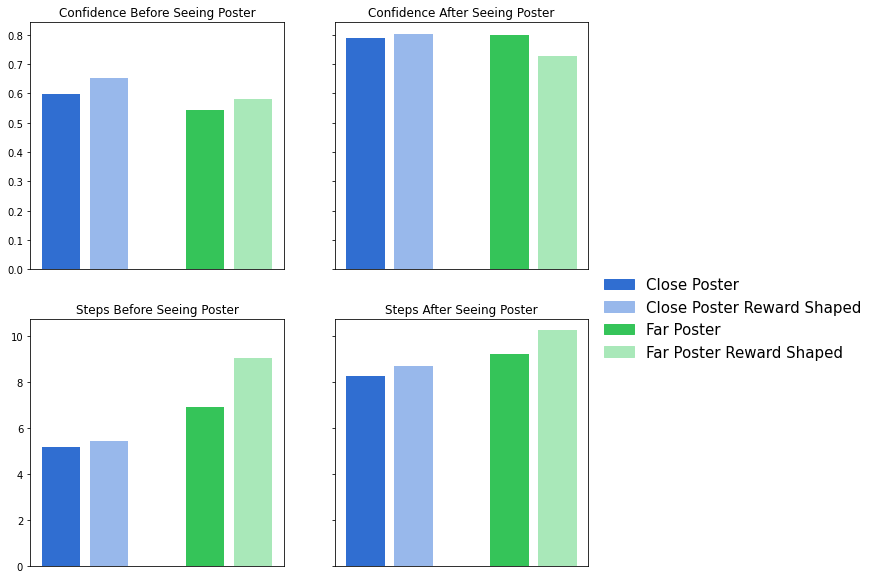

In [93]:

plot_names = ['Confidence Before Seeing Poster', 'Confidence After Seeing Poster',
              'Steps Before Seeing Poster', 'Steps After Seeing Poster']
bar_names = ['Close Poster', 'Close Poster Reward Shaped', 'Far Poster', 'Far Poster Reward Shaped']
positions = [0, 1, 3, 4]
colors = ['#306ed1', '#98b8eb', '#35c459', '#a9e8b9']

fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharey='row')
for i, d in enumerate(dict_names):
    x = i % 2
    y = i // 2
    ys = []
    for name in names:
        ys.append(mean_mean_dicts[d][name])
    ax[y, x].bar(positions, ys, color=colors)
    ax[y, x].set_title(plot_names[i])
    ax[y, x].set_xticks([])
    
patches = []
for i in range(4):
    patches.append(Patch(color=colors[i], label=bar_names[i])) 

# add the legend
plt.legend(labels=bar_names, handles=patches, bbox_to_anchor=(1.04, 1), loc='center left', borderaxespad=0, fontsize=15, frameon=False)
plt.savefig(save_folder + 'poster_confidence', bbox_inches='tight')


### Hidden State Dynamics

In [16]:
model, obs_rms, env_kwargs = load_model_and_env('invisible_poster/invisible_poster_1_shape_1_4.pt')
evalu(200)


 Evaluation using 200 episodes: mean reward 1.15934



 Evaluation using 200 episodes: mean reward 1.15934



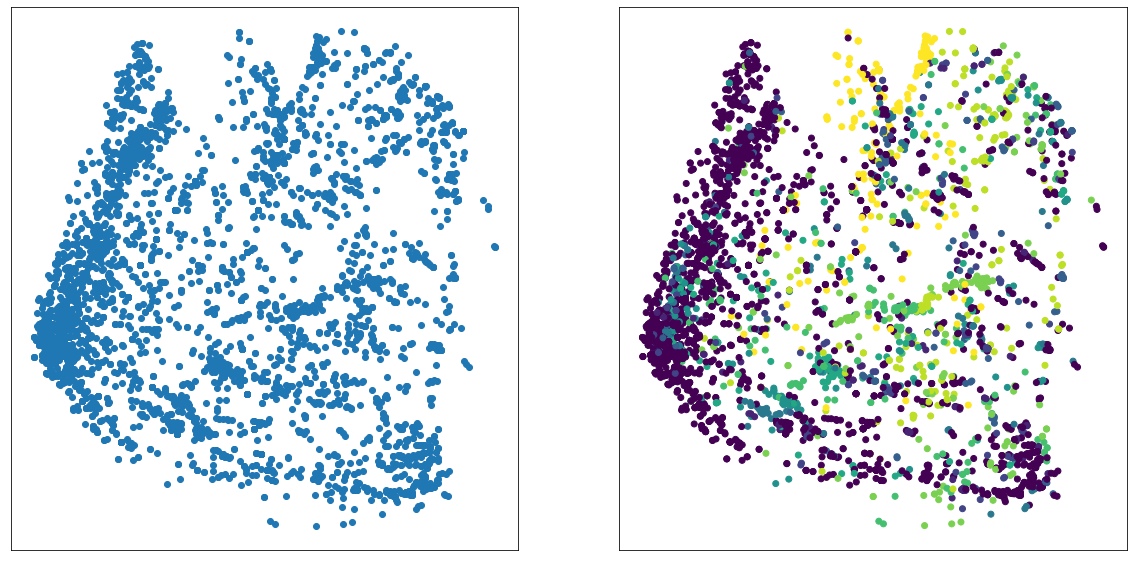

In [137]:
model, obs_rms, env_kwargs = load_model_and_env('invisible_poster/invisible_poster_1_shape_1_4.pt')
evalu(200)

traj_points_x = []
traj_points_y = []
colors = []

cur_color = 0
spotted = False
for ep_num in range(len(ep_ends)):
    first_poster_sighting = np.argmax(get_ep(data['poster_in_sight'], ep_num))
    traj = get_ep(all_trajectories, ep_num)
    for i, t in enumerate(traj):
        traj_points_x.append(t[0])
        traj_points_y.append(t[1])
        if i <= first_poster_sighting:
            colors.append(0)
        else:
            if not spotted:
                cur_color = 10
                spotted = True
                colors.append(cur_color)
            else:
                cur_color = cur_color - 1
                if cur_color < 0:
                    cur_color = 0
                colors.append(cur_color)
    cur_color = 0
    spotted = False
        

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
ax[0].scatter(traj_points_x, traj_points_y)
ax[1].scatter(traj_points_x, traj_points_y, c=colors)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.savefig(save_folder + 'poster_trajectories_1_1_4', bbox_inches='tight')

 Evaluation using 200 episodes: mean reward 1.13890



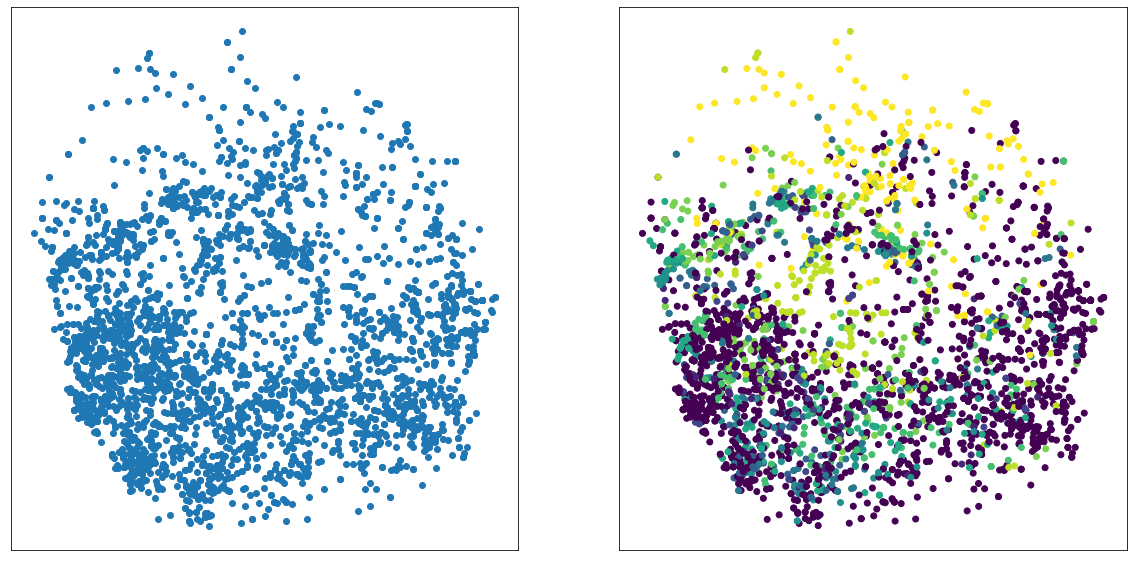

In [139]:
model, obs_rms, env_kwargs = load_model_and_env('invisible_poster/invisible_poster_1_shape_1_3.pt')
evalu(200)

traj_points_x = []
traj_points_y = []
colors = []

cur_color = 0
spotted = False
for ep_num in range(len(ep_ends)):
    first_poster_sighting = np.argmax(get_ep(data['poster_in_sight'], ep_num))
    traj = get_ep(all_trajectories, ep_num)
    for i, t in enumerate(traj):
        traj_points_x.append(t[0])
        traj_points_y.append(t[1])
        if i <= first_poster_sighting:
            colors.append(0)
        else:
            if not spotted:
                cur_color = 10
                spotted = True
                colors.append(cur_color)
            else:
                cur_color = cur_color - 1
                if cur_color < 0:
                    cur_color = 0
                colors.append(cur_color)
    cur_color = 0
    spotted = False
        

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
ax[0].scatter(traj_points_x, traj_points_y)
ax[1].scatter(traj_points_x, traj_points_y, c=colors)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.savefig(save_folder + 'poster_trajectories_1_1_3', bbox_inches='tight')

 Evaluation using 200 episodes: mean reward 1.00000



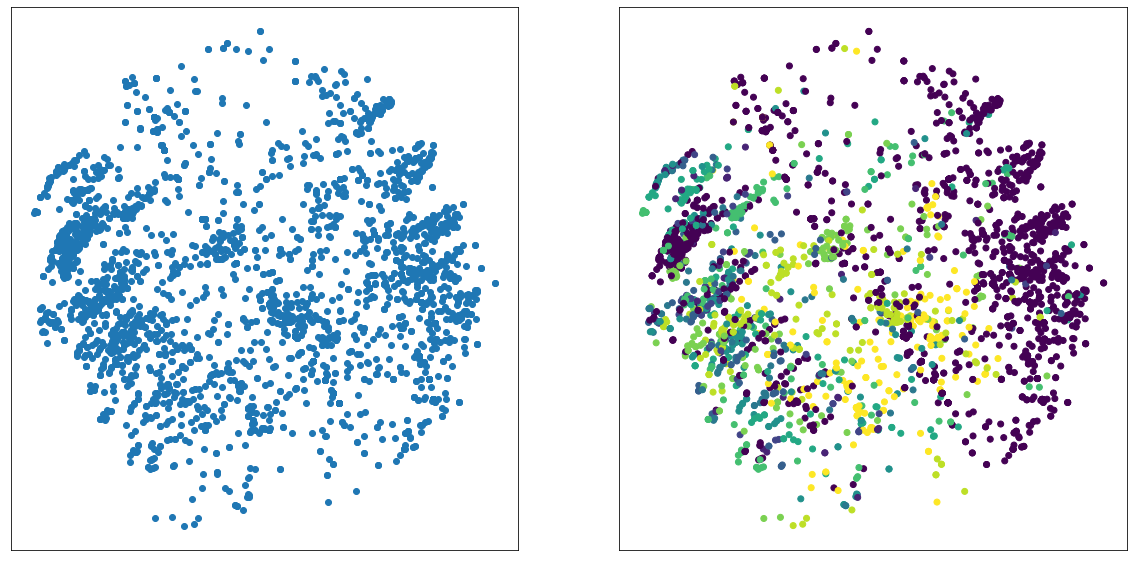

In [140]:
model, obs_rms, env_kwargs = load_model_and_env('invisible_poster/invisible_poster_1_shape_0_4.pt')
evalu(200)

traj_points_x = []
traj_points_y = []
colors = []

cur_color = 0
spotted = False
for ep_num in range(len(ep_ends)):
    first_poster_sighting = np.argmax(get_ep(data['poster_in_sight'], ep_num))
    traj = get_ep(all_trajectories, ep_num)
    for i, t in enumerate(traj):
        traj_points_x.append(t[0])
        traj_points_y.append(t[1])
        if i <= first_poster_sighting:
            colors.append(0)
        else:
            if not spotted:
                cur_color = 10
                spotted = True
                colors.append(cur_color)
            else:
                cur_color = cur_color - 1
                if cur_color < 0:
                    cur_color = 0
                colors.append(cur_color)
    cur_color = 0
    spotted = False
        

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
ax[0].scatter(traj_points_x, traj_points_y)
ax[1].scatter(traj_points_x, traj_points_y, c=colors)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.savefig(save_folder + 'poster_trajectories_1_0_4', bbox_inches='tight')

 Evaluation using 200 episodes: mean reward 1.00000



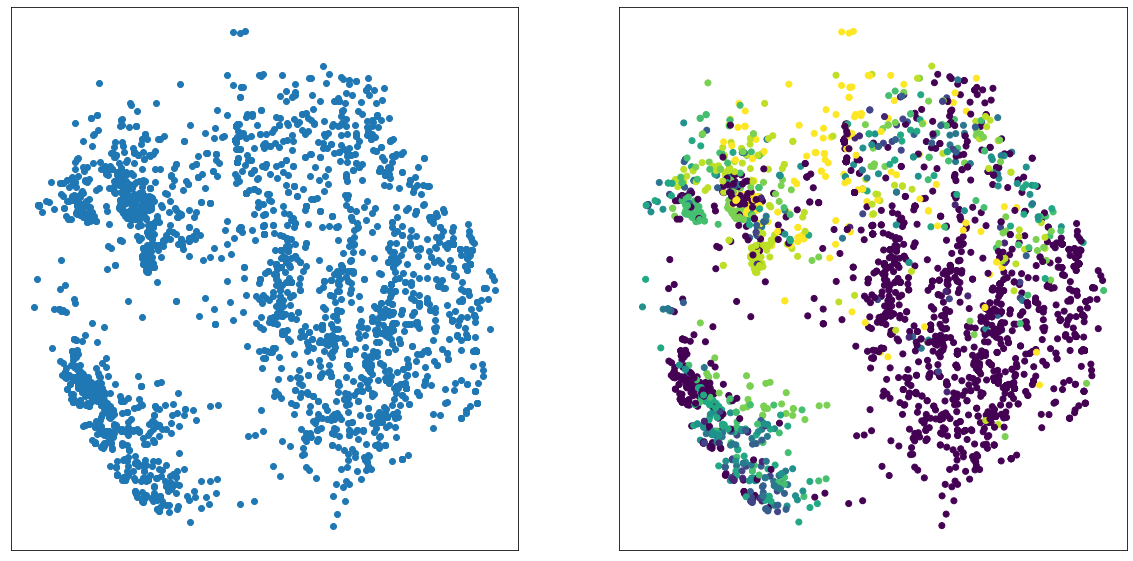

In [141]:
model, obs_rms, env_kwargs = load_model_and_env('invisible_poster/invisible_poster_1_shape_0_3.pt')
evalu(200)

traj_points_x = []
traj_points_y = []
colors = []

cur_color = 0
spotted = False
for ep_num in range(len(ep_ends)):
    first_poster_sighting = np.argmax(get_ep(data['poster_in_sight'], ep_num))
    traj = get_ep(all_trajectories, ep_num)
    for i, t in enumerate(traj):
        traj_points_x.append(t[0])
        traj_points_y.append(t[1])
        if i <= first_poster_sighting:
            colors.append(0)
        else:
            if not spotted:
                cur_color = 10
                spotted = True
                colors.append(cur_color)
            else:
                cur_color = cur_color - 1
                if cur_color < 0:
                    cur_color = 0
                colors.append(cur_color)
    cur_color = 0
    spotted = False
        

fig, ax = plt.subplots(1, 2, figsize=(20, 10), sharex=True, sharey=True)
ax[0].scatter(traj_points_x, traj_points_y)
ax[1].scatter(traj_points_x, traj_points_y, c=colors)
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.savefig(save_folder + 'poster_trajectories_1_0_3', bbox_inches='tight')

# Record Video

In [4]:
print_trained_models()

ppo
├── invisible_poster
│   ├── EXP invisible_poster_0_shape_0: 5
│   ├── EXP invisible_poster_0_shape_1: 5
│   ├── EXP invisible_poster_1_shape_0: 5
│   ├── EXP invisible_poster_1_shape_1: 5
├── invisible_wallcolors
│   ├── EXP invisible_0_1: 10
│   ├── EXP invisible_0_2.5: 3
│   ├── EXP invisible_0_2: 3
│   ├── EXP invisible_0_4: 3
│   ├── EXP invisible_1_1: 10
│   ├── EXP invisible_1_2.5: 3
│   ├── EXP invisible_1_2: 3
│   ├── EXP invisible_1_4: 3
├── nav_invisible_wallcolors
│   ├── EXP nav_invisible_color_1_dist: 3
│   ├── EXP nav_invisible_color_2.5_dist: 5
│   ├── EXP nav_invisible_color_2.5_none: 5
│   ├── EXP nav_invisible_color_2_dist: 5
│   ├── EXP nav_invisible_color_2_none: 5
│   ├── EXP nav_invisible_color_4_dist: 5
│   ├── EXP nav_invisible_color_4_none: 5
├── nav_visible_reshaping
│   ├── EXP nav_visible_dist: 5
│   ├── EXP nav_visible_none: 5
├── visible_reshaping
│   ├── EXP grid_reshaping_0: 9
│   ├── EXP grid_reshaping_1: 9
│   ├── EXP grid_reshaping_2: 7
│   ├── E

In [15]:
# Example of basic visible grid nav
# model, obs_rms, env_kwargs = load_model_and_env('visible_reshaping/grid_reshaping_1_0.pt')
# evalu(n=2, env_name='Gridworld-v0', capture_video=1, verbose=True)

# Example of continuous nav
# model, obs_rms, env_kwargs = load_model_and_env('nav_visible_reshaping/nav_visible_dist_0.pt')
# evalu(n=2, env_name='NavEnv-v0', capture_video=1, verbose=True)


# Example of continuous nav
model, obs_rms, env_kwargs = load_model_and_env('nav_invisible_wallcolors/nav_invisible_color_2_none_0.pt')
evalu(n=10, env_name='NavEnv-v0', capture_video=1, verbose=True)

C:\Users\Andy\miniconda3\lib\site-packages\gym\wrappers\record_video.py:42: UserWarning: WARN: Overwriting existing videos at C:\Users\Andy\Desktop\Work\github\training-rl-algo\write_and_test\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


ep 1 rew 0
ep 2 rew 0
ep 3 rew 1.0
ep 4 rew 1.0
ep 5 rew 1.0
ep 6 rew 0
ep 7 rew 1.0
ep 8 rew 0
ep 9 rew 0
ep 10 rew 0
 Evaluation using 10 episodes: mean reward 0.40000



In [5]:
evalu(n=2, env_name='NavEnv-v0', capture_video=1, verbose=True)

C:\Users\Andy\miniconda3\lib\site-packages\gym\wrappers\record_video.py:42: UserWarning: WARN: Overwriting existing videos at C:\Users\Andy\Desktop\Work\github\training-rl-algo\write_and_test\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


ep 1 rew 1.494484
ep 2 rew 1.133869
 Evaluation using 2 episodes: mean reward 1.31418



In [6]:
evalu(n=2, env_name='NavEnv-v0', capture_video=1, verbose=True)

C:\Users\Andy\miniconda3\lib\site-packages\gym\wrappers\record_video.py:42: UserWarning: WARN: Overwriting existing videos at C:\Users\Andy\Desktop\Work\github\training-rl-algo\write_and_test\video folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


ep 1 rew 1.494484
ep 2 rew 1.133869
 Evaluation using 2 episodes: mean reward 1.31418

